항체의약품을 개발하는 과정은 시간과 비용이 많이 들고 성공 확률 또한 낮습니다. 수많은 후보 항체 중 어떤 것이 임상 개발까지 이어질지 예측하는 것은 마치 '바늘찾기'와 같습니다.

이러한 문제를 해결하기 위해 인공지능 기술이 바이오 의약품 개발에 접목되고 있습니다. 특히 딥러닝 기술은 방대한 양의 데이터를 학습하여 항체 후보 물질의 특성을 예측하고, 개발 성공 가능성을 높이는 데 기여하고 있습니다. 오늘은 [DeepSP]()라는 딥러닝 기반 모델을 통해 항체 의약품의 개발 가능성을 예측하는 방법을 알아보고자 합니다. 이 튜토리얼은 여러분이 복잡한 계산이나 전문 지식 없이도 DeepSP 모델을 이해하고 활용할 수 있도록 돕는 것을 목표로 합니다.

# 사용된 도구

- [ANARCI](https://github.com/oxpig/ANARCI) 항체 서열에서 CDR 영역을 식별하고, 이를 표준화된 형식으로 변환하는 도구입니다.
- [DeepSP](https://github.com/Lailabcode/DeepSP)는 항체 CDR 영역의 서열 데이터를 입력받아, 단백질 구조 데이터 없이 해당 항체의 공간적인 특성을 예측하는 모델입니다. 30가지의 공간적 특성을 생성하며 이 값들은 이후의 모델의 입력 데이터로 사용됩니다.
- [DeepViscosity](https://github.com/Lailabcode/DeepViscosity) 는 고농도 단일 클론 항체 점도 등급(낮음: 20 cP 이하, 높음: 20 cP 초과)을 예측하기 위해 개발된 앙상블 딥러닝 인공신경망(ANN) 모델입니다. 이 모델은 DeepSP 대리 모델로부터 얻은 30가지 공간 특성(기술자)을 훈련을 위한 특징으로 활용했습니다. 총 229개의 단일 클론 항체(mAb)를 기반으로 훈련되었습니다.
- [AbDev](https://github.com/Lailabcode/AbDev) 는 단일 클론 항체(mAb)의 12가지 주요 생물물리학적 특성 분석을 위해 설계된 포괄적인 예측 모델입니다. 이 도구는 딥러닝 기반 도구인 DeepSP와 머신러닝 기법을 결합해 단일 클론 항체의 통찰력을 제공합니다.


In [ ]:
# | echo: false

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

# ANARCI 로 CDR 영역 식별하기

먼저 분석에 사용할 데이터를 준비합니다. 여기에서는 `seq_H.fasta`과 `seq_L.fasta` 파일을 사용합니다. 이 파일들은 각각 항체의 Heavy chain과 Light chain 서열을 포함하고 있습니다. ANARCI를 사용하여 CDR 영역을 식별하고, 이를 표준화된 형식으로 변환합니다.

먼저 `seq_H.fasta` 파일의 일부를 살펴봅시다.

In [2]:
!head -10  ../data/example/seq_H.fasta

>abituzumab
QVQLQQSGGELAKPGASVKVSCKASGYTFSSFWMHWVRQAPGQGLEWIGYINPRSGYTEY
NEIFRDKATMTTDTSTSTAYMELSSLRSEDTAVYYCASFLGRGAMDYWGQGTTVTVSS
>abrilumab
QVQLVQSGAEVKKPGASVKVSCKVSGYTLSDLSIHWVRQAPGKGLEWMGGFDPQDGETIY
AQKFQGRVTMTEDTSTDTAYMELSSLKSEDTAVYYCATGSSSSWFDPWGQGTLVTVSS
>adalimumab
EVQLVESGGGLVQPGRSLRLSCAASGFTFDDYAMHWVRQAPGKGLEWVSAITWNSGHIDY
ADSVEGRFTISRDNAKNSLYLQMNSLRAEDTAVYYCAKVSYLSTASSLDYWGQGTLVTVS
S


동일하게 `seq_L.fasta` 파일도 확인합니다.

In [3]:
!head -10  ../data/example/seq_L.fasta

>abituzumab
DIQMTQSPSSLSASVGDRVTITCRASQDISNYLAWYQQKPGKAPKLLIYYTSKIHSGVPS
RFSGSGSGTDYTFTISSLQPEDIATYYCQQGNTFPYTFGQGTKVEIK
>abrilumab
DIQMTQSPSSVSASVGDRVTITCRASQGISSWLAWYQQKPGKAPKLLIYGASNLESGVPS
RFSGSGSGTDFTLTISSLQPEDFANYYCQQANSFPWTFGQGTKVEIK
>adalimumab
DIQMTQSPSSLSASVGDRVTITCRASQGIRNYLAWYQQKPGKAPKLLIYAASTLQSGVPS
RFSGSGSGTDFTLTISSLQPEDVATYYCQRYNRAPYTFGQGTKVEIK
>alemtuzumab


위 출력을 통해 각 항체 서열이 동일한 이름이고 각 heavy chain과 light chain인 파일로 구분되어 있음을 알 수 있습니다. 이제 ANARCI를 사용하여 이 서열들에서 CDR 영역을 식별하고, 이를 표준화된 형식으로 변환합니다.

## ANARCI 실행

아래 명령어를 통해 각 서열에 파일에 대한 서열 정렬과 CDR 영역을 식별할 수 있습니다.

- `-p` 옵션은 CPU 코어 수를 지정합니다. 여기에서는 30개를 사용했습니다.
- 주피터 노트북안에서 실행해서 SyntaxWarning이 발생했습니다. 터미널에서 실행할때는 문제가 없을 것입니다.

In [4]:
!ANARCI -i ../data/example/seq_H.fasta -o ../data/example/seq_aligned -p 30 -s imgt -r heavy --csv
!ANARCI -i ../data/example/seq_L.fasta -o ../data/example/seq_aligned -p 30 -s imgt -r light --csv

/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/AbDev/.pixi/envs/default/bin/ANARCI:13: SyntaxWarning: invalid escape sequence '\ '
  ANARCI                                                 \\\    //
/mnt/c4a1c56d-0589-48cd-9717-f6c33a86fa3b/Tools/AbDev/.pixi/envs/default/bin/ANARCI:13: SyntaxWarning: invalid escape sequence '\ '
  ANARCI                                                 \\\    //


# DeepSP

이제 DeepSP 모델을 사용해서 CDR 영역의 서열 데이터를 입력받아 단백질 구조 데이터 없이 해당 항체의 공간적인 특성을 예측합니다. 이 모델은 30가지의 공간적 특성을 생성하며, 이 값들은 이후의 모델의 입력 데이터로 사용됩니다.

## 서열 데이터 전처리

중쇄(heavy chain)와 경쇄(light chain) 서열 데이터를 읽고 단일 텍스트 파일로 만드는 전처리를 진행합니다.


In [5]:
import pandas as pd


def seq_preprocessing(infile_H_path: str, infile_L_path: str, outfile_path: str) -> None:
    """
    중쇄와 경쇄 시퀀스 데이터를 CSV 파일에서 읽어 처리하고,
    결합된 시퀀스를 단일 텍스트 파일로 작성합니다.

    Args:
        infile_H_path: 중쇄 시퀀스 CSV 파일 경로
        infile_L_path: 경쇄 시퀀스 CSV 파일 경로
        outfile_path: 출력 텍스트 파일 경로
    """
    try:
        infile_H: pd.DataFrame = pd.read_csv(infile_H_path)
        infile_L: pd.DataFrame = pd.read_csv(infile_L_path)
    except FileNotFoundError as e:
        print(f"Error: A required file was not found. {e}")
        return
    except pd.errors.EmptyDataError:
        print("Error: One of the input CSV files is empty.")
        return

    h_list_base: list[str] = [str(i) for i in range(1, 112)]
    h_list_suffixes: list[str] = [f"111{s}" for s in ["A", "B", "C", "D", "E", "F", "G", "H"]] + [
        f"112{s}" for s in ["I", "H", "G", "F", "E", "D", "C", "B", "A"]
    ]
    h_list_end: list[str] = [str(i) for i in range(112, 129)]
    H_inclusion_list: list[str] = h_list_base + h_list_suffixes + h_list_end
    L_inclusion_list: list[str] = [str(i) for i in range(1, 128)]

    H_columns_to_select: list[str] = [col for col in H_inclusion_list if col in infile_H.columns]
    L_columns_to_select: list[str] = [col for col in L_inclusion_list if col in infile_L.columns]

    H_seq_data: pd.DataFrame = infile_H.loc[:, H_columns_to_select].fillna("-")
    L_seq_data: pd.DataFrame = infile_L.loc[:, L_columns_to_select].fillna("-")

    H_seq_series: pd.Series = H_seq_data.apply(lambda row: "".join(row.values.astype(str)), axis=1)
    L_seq_series: pd.Series = L_seq_data.apply(lambda row: "".join(row.values.astype(str)), axis=1)

    combined_seq_series: pd.Series = H_seq_series + L_seq_series
    output_series: pd.Series = infile_H["Id"].astype(str) + " " + combined_seq_series.astype(str)

    with open(outfile_path, "w") as outfile:
        outfile.write("\n".join(output_series))


PATH: str = "../data/example/"
seq_preprocessing(
    PATH + "seq_aligned_H.csv", PATH + "seq_aligned_KL.csv", PATH + "seq_aligned_HL.csv"
)

전처리가 완료되면 `seq_aligned_HL.csv` 파일이 생성됩니다. 이 파일은 DeepSP 모델에 입력될 준비가 된 데이터입니다. 이제 이 파일을 사용하여 DeepSP 모델을 실행할 수 있습니다.

## DeepSP 모델 실행


In [ ]:
import numpy as np
from keras.models import model_from_json
from tensorflow.keras.models import Sequential, model_from_json


def load_pred_data(filename: str) -> tuple[list[str], list[str]]:
    name_list: list[str] = []
    seq_list: list[str] = []
    with open(filename) as datafile:
        for line in datafile:
            line = line.strip().split()
            name_list.append(line[0])
            seq_list.append(line[1])
    return name_list, seq_list


def one_hot_encoder(s: str) -> np.ndarray:
    d: dict[str, int] = {
        "A": 0,
        "C": 1,
        "D": 2,
        "E": 3,
        "F": 4,
        "G": 5,
        "H": 6,
        "I": 7,
        "K": 8,
        "L": 9,
        "M": 10,
        "N": 11,
        "P": 12,
        "Q": 13,
        "R": 14,
        "S": 15,
        "T": 16,
        "V": 17,
        "W": 18,
        "Y": 19,
        "-": 20,
    }

    x: np.ndarray = np.zeros((len(d), len(s)))
    x[[d[c] for c in s], range(len(s))] = 1
    return x


name_list, seq_list = load_pred_data(PATH + "seq_aligned_HL.txt")

for prop in ["SAPpos", "SCMpos", "SCMneg"]:
    json_file = open("../models/Conv1D_regression" + prop + ".json")
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = model_from_json(loaded_model_json, custom_objects={"Sequential": Sequential})

    # load weights into model
    loaded_model.load_weights("../models/Conv1D_regression_" + prop + ".h5")

    X = [one_hot_encoder(s=x) for x in seq_list]
    X = np.transpose(np.asarray(X), (0, 2, 1))
    X = np.asarray(X)

    loaded_model.compile(optimizer="adam", loss="mae", metrics=["mae"])
    y_pred = loaded_model.predict(X)

    outfile = open(PATH + "pnas_deep" + prop + ".csv", "w")

    for i in range(len(y_pred)):
        outfile.write(f"{name_list[i]} {' '.join([f'{num:.2f}' for num in y_pred[i]])}")
        outfile.write("\n")

    outfile.close()

df_pnas_SAPpos = pd.read_csv(PATH + "pnas_deepSAPpos.csv", delimiter=" ", header=None)
df_pnas_SAPpos.columns = [
    "Name",
    "SAP_pos_CDRH1",
    "SAP_pos_CDRH2",
    "SAP_pos_CDRH3",
    "SAP_pos_CDRL1",
    "SAP_pos_CDRL2",
    "SAP_pos_CDRL3",
    "SAP_pos_CDR",
    "SAP_pos_Hv",
    "SAP_pos_Lv",
    "SAP_pos_Fv",
]

df_pnas_SCMpos = pd.read_csv(PATH + "pnas_deepSCMpos.csv", delimiter=" ", header=None)
df_pnas_SCMpos.columns = [
    "Name",
    "SCM_pos_CDRH1",
    "SCM_pos_CDRH2",
    "SCM_pos_CDRH3",
    "SCM_pos_CDRL1",
    "SCM_pos_CDRL2",
    "SCM_pos_CDRL3",
    "SCM_pos_CDR",
    "SCM_pos_Hv",
    "SCM_pos_Lv",
    "SCM_pos_Fv",
]

df_pnas_SCMneg = pd.read_csv(PATH + "pnas_deepSCMneg.csv", delimiter=" ", header=None)
df_pnas_SCMneg.columns = [
    "Name",
    "SCM_neg_CDRH1",
    "SCM_neg_CDRH2",
    "SCM_neg_CDRH3",
    "SCM_neg_CDRL1",
    "SCM_neg_CDRL2",
    "SCM_neg_CDRL3",
    "SCM_neg_CDR",
    "SCM_neg_Hv",
    "SCM_neg_Lv",
    "SCM_neg_Fv",
]

merged_df = df_pnas_SAPpos.merge(df_pnas_SCMneg, on="Name", how="inner")
df_deepsp = merged_df.merge(df_pnas_SCMpos, on="Name", how="inner")

df_deepsp.to_csv(PATH + "SAPSCM.csv", index=False)

2025-08-22 16:52:19.201950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-22 16:52:19.220436: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x79cf3848f7e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


예측이 완료되면 이제 결과를 확인해봅니다.

In [7]:
print(df_deepsp.head())

          Name  SAP_pos_CDRH1  SAP_pos_CDRH2  SAP_pos_CDRH3  SAP_pos_CDRL1  \
0   abituzumab           3.86           4.35           8.72           2.15   
1    abrilumab           3.42           1.08           1.83           2.09   
2   adalimumab           2.13           2.52          14.45           1.90   
3  alemtuzumab           2.27           3.70           5.04           2.22   
4   alirocumab           2.34           0.49           5.75           6.34   

   SAP_pos_CDRL2  SAP_pos_CDRL3  SAP_pos_CDR  SAP_pos_Hv  SAP_pos_Lv  ...  \
0           4.70           6.79        30.68       45.53       36.43  ...   
1           2.40           6.01        17.93       43.01       31.23  ...   
2           3.59           3.17        27.50       58.42       30.52  ...   
3           2.76           3.33        20.66       52.66       32.29  ...   
4           2.48           4.47        23.01       52.35       43.46  ...   

   SCM_pos_CDRH1  SCM_pos_CDRH2  SCM_pos_CDRH3  SCM_pos_CDRL1  SCM_p

위 결과를 보면 전체적으로 SAP와 SCM의로 구분되어 있는데, SAP는 응집도(Aggregation)와 관련된 특성이고 SCM는 전하(Charge)와 관련된 것입니다. 그리고 전하가 postive인지 negative인지에 따라 구분되고 CDR 영역에 따라 CDR1, CDR2, CDR3, Hv(heavy chain variable region), Lv(light chain variable region)등으로 구분되어 있습니다.


# DeepViscosity 예측

이제 DeepSP 모델을 통해 생성된 30가지의 공간적 특성을 사용하여 DeepViscosity 모델을 실행합니다. 이 모델은 단일 클론 항체의 점도 등급(낮음: 20 cP 이하, 높음: 20 cP 초과)을 예측합니다. 즉, 결과값이 `1`이면 높은 점도(>20 cP), `0`이면 낮은 점도(<=20 cP)를 의미합니다.

In [8]:
import joblib
from keras.layers import (
    BatchNormalization,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling1D,
)
from keras.models import model_from_json
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

X = df_deepsp.iloc[:, 1:]

scaler = joblib.load("../data/DeepViscosity_scaler/DeepViscosity_scaler.save")
X_scaled = scaler.transform(X)

# Add any other custom layers or classes to this dictionary if necessary
custom_objects = {
    "Sequential": Sequential,
    "Conv1D": Conv1D,
    "BatchNormalization": BatchNormalization,
    "Dropout": Dropout,
    "MaxPooling1D": MaxPooling1D,
    "Flatten": Flatten,
    "Dense": Dense,
}


def load_and_compile_model(json_path: str, weights_path: str) -> Sequential:
    """
    JSON 파일에서 모델을 로드하고 컴파일합니다.

    Args:
        json_path: 모델 아키텍처 JSON 파일 경로
        weights_path: 모델 가중치 파일 경로

    Returns:
        컴파일된 Keras Sequential 모델
    """
    with open(json_path) as json_file:
        loaded_model_json: str = json_file.read()

    loaded_model: Sequential = model_from_json(loaded_model_json, custom_objects=custom_objects)
    loaded_model.load_weights(weights_path)
    loaded_model.compile(optimizer=Adam(0.0001), metrics=["accuracy"])

    return loaded_model


model_preds = []

for i in range(102):
    file = "ANN_logo_" + str(i)
    model = load_and_compile_model(
        "../data/DeepViscosity_ANN_ensemble_models/" + file + ".json",
        "../data/DeepViscosity_ANN_ensemble_models/" + file + ".h5",
    )
    pred = model.predict(X_scaled, verbose=0)
    model_preds.append(pred)

model_preds = np.array(model_preds)  # shape: (102, num_samples, 1)

# Calculate mean and std of probabilities
prob_mean = model_preds.mean(axis=0).flatten()  # shape: (num_samples,)
prob_std = model_preds.std(axis=0).flatten()

# Final class prediction by majority vote (threshold=0.5 on mean probability)
final_pred = (prob_mean >= 0.5).astype(int)

# Combine into DataFrame
df_deepvis = pd.DataFrame(
    {
        "Name": name_list,
        "Prob_Mean": prob_mean,
        "Prob_Std": prob_std,
        "DeepViscosity_classes": final_pred,
    }
)

df_deepvis.to_csv(PATH + "DeepViscosity_classes.csv", index=False)

print(df_deepvis.head(10))

           Name  Prob_Mean  Prob_Std  DeepViscosity_classes
0    abituzumab   0.357939  0.103836                      0
1     abrilumab   0.377713  0.145445                      0
2    adalimumab   0.304624  0.130675                      0
3   alemtuzumab   0.356850  0.099767                      0
4    alirocumab   0.230954  0.102446                      0
5   anifrolumab   0.453420  0.121212                      0
6  atezolizumab   0.540349  0.120598                      1
7  bapineuzumab   0.402443  0.099362                      0
8   basiliximab   0.202554  0.090979                      0
9   bavituximab   0.429734  0.125953                      0


위 결과를 보면 모델의 예측 값의 평균과 표준 편차를 확인 할 수 있고 평균이 0.5 이상이면 class를 1로 하고 있는 것을 알 수 있습니다. 자세한 결과는 아래 시각화에서 다시 살펴보겠습니다.

# AbDev로 단일 클론 항체의 생물물리학적 특성 예측

이제 AbDev 모델을 사용하여 단일 클론 항체의 12가지 주요 생물물리학적 특성을 예측합니다. 이 모델은 DeepSP와 머신러닝 기법을 결합하여 단일 클론 항체의 통찰력을 제공합니다.


In [ ]:
import os

import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def predict_biophysical_properties(data_path: str, models_dir: str) -> pd.DataFrame:
    """
    CSV 파일을 읽어와서 여러 모델에 필요한 특징을 전처리하고, 사전 훈련된 모델을 불러와 예측을 수행한 후, 그 결과를 CSV 파일로 저장합니다.
    * `data_path` (str): 입력 CSV 파일 경로 (예: 'SAPSCM.csv').
    * `models_dir` (str): 훈련된 모델의 joblib 파일이 있는 디렉터리.
    Returns):
        `pd.DataFrame`: 각 샘플에 대한 예측된 생물물리학적 특성을 포함하는 데이터프레임. 오류가 발생하면 빈 데이터프레임을 반환합니다.
    """
    try:
        # Load the input data
        df = pd.read_csv(data_path)
    except FileNotFoundError:
        print(f"Error: The file at {data_path} was not found.")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return pd.DataFrame()

    # Define the features and their corresponding model types and filenames
    prediction_configs = {
        "ACSINS": {
            "features": [
                "SAP_pos_CDRH2",
                "SAP_pos_CDRL3",
                "SCM_pos_CDRH1",
                "SCM_neg_CDR",
            ],
            "model_type": "SVR",
        },
        "AS": {
            "features": [
                "SAP_pos_CDRH3",
                "SCM_pos_CDRL2",
                "SCM_pos_CDRL3",
                "SCM_neg_CDRL3",
            ],
            "model_type": "LR",
        },
        "BVP": {
            "features": [
                "SAP_pos_CDRH2",
                "SAP_pos_CDRH3",
                "SCM_pos_CDR",
                "SCM_neg_CDRH3",
            ],
            "model_type": "KNN",
        },
        "CIC": {
            "features": ["SAP_pos_CDRL3", "SAP_pos_CDRL3", "SAP_pos_Lv", "SCM_neg_CDR"],
            "model_type": "KNN",
        },
        "CSI": {
            "features": [
                "SAP_pos_CDRL1",
                "SAP_pos_Lv",
                "SCM_pos_CDRH2",
                "SCM_neg_CDRL2",
            ],
            "model_type": "SVR",
        },
        "ELISA": {
            "features": ["SAP_pos_CDRH3", "SCM_pos_CDR", "SCM_neg_CDR"],
            "model_type": "KNN",
        },
        "HIC": {
            "features": ["SAP_pos_CDRL3", "SAP_pos_CDR", "SAP_pos_Hv", "SCM_pos_CDRH3"],
            "model_type": "SVR",
        },
        "HEK": {
            "features": ["SAP_pos_CDRH2", "SAP_pos_CDRL3", "SCM_pos_Lv", "SCM_neg_Lv"],
            "model_type": "KNN",
        },
        "PSR": {
            "features": ["SAP_pos_Lv", "SCM_pos_CDRH2", "SCM_neg_CDRL2"],
            "model_type": "SVR",
        },
        "SGAC": {
            "features": [
                "SAP_pos_CDRH1",
                "SAP_pos_CDRL3",
                "SCM_neg_CDRH2",
                "SCM_neg_Lv",
            ],
            "model_type": "SVR",
        },
        "SMAC": {
            "features": ["SAP_pos_CDR", "SAP_pos_Fv", "SCM_neg_CDRL2", "SCM_neg_Fv"],
            "model_type": "KNN",
        },
        "Tm": {
            "features": ["SAP_pos_CDRH1", "SAP_pos_CDRH2", "SCM_pos_CDRH3"],
            "model_type": "KNN",
        },
    }

    sc = StandardScaler()
    results = {}

    for prop_name, config in prediction_configs.items():
        features = config["features"]
        model_type = config["model_type"]

        # Select features from the DataFrame and transform them
        try:
            X = df[features].values
            # Check if features exist to avoid KeyError
            if X.shape[1] != len(features):
                print(f"Warning: Not all features for {prop_name} were found. Skipping.")
                continue

            # Transform the feature data
            X_scaled = sc.fit_transform(X)

            # Construct the model file path
            model_file = f"{prop_name}_{model_type}_model.joblib"
            model_path = os.path.join(models_dir, model_file)

            # Load the model
            model = joblib.load(model_path)

            # Make a prediction and store the result
            results[prop_name] = model.predict(X_scaled)

        except KeyError as e:
            print(f"Error: Missing columns for property {prop_name}. Columns: {e}")
            continue
        except FileNotFoundError:
            print(f"Error: Model file not found at {model_path}. Skipping.")
            continue
        except Exception as e:
            print(f"An unexpected error occurred for {prop_name}: {e}")
            continue

    if not results:
        print("No predictions were successfully made. Returning empty DataFrame.")
        return pd.DataFrame()

    # Combine all results into a single DataFrame
    result_df = pd.DataFrame(results, index=df["Name"])
    result_df.index.name = "Name"
    result_df.reset_index(inplace=True)

    return result_df


# Define paths
PATH = "../data/example/"
MODELS_DIR = "../models/Trained_model"

# Load the data and predict properties
results_df = predict_biophysical_properties(os.path.join(PATH, "SAPSCM.csv"), MODELS_DIR)

if not results_df.empty:
    # Save the results to a new CSV file
    output_path = os.path.join(PATH, "AbDev_result.csv")
    results_df.to_csv(output_path, index=False)

    # Display the first few rows of the final DataFrame
    print(results_df.head())

          Name    ACSINS        AS       BVP       CIC       CSI     ELISA  \
0   abituzumab  0.099237  0.058404  2.760843 -0.175841  0.754452  1.246774   
1    abrilumab -2.310574  0.027978  1.504088 -1.883633 -0.567603  1.098520   
2   adalimumab  0.015226  0.052934  1.850250  0.366372  0.009078  1.106229   
3  alemtuzumab  0.425335  0.075874  3.922812  0.009560  0.573666  2.792832   
4   alirocumab -0.105197  0.046605  2.811663 -0.402932 -0.169576  1.150019   

        HIC         HEK       PSR      SGAC      SMAC         Tm  
0  9.611033  110.547472  0.213440  0.092682 -0.609231  74.083333  
1  9.174332  133.475483  0.094551  0.499488 -0.764255  76.166667  
2  9.404225  115.630949  0.077331  0.318433 -0.461127  72.333333  
3  9.472621  150.744013  0.372855  0.576464 -0.930367  67.500000  
4  9.536504  120.915541  0.130635  0.312652  0.007218  75.416667  


다양한 예측 결과를 알 수 있는데, 구체적인 내용은 해당 [논문](https://pubs.acs.org/doi/10.1021/acs.molpharmaceut.4c00804)을 참고하시기 바랍니다. 여기서 사용된 12개의 지표들은 [참고 문헌](https://www.pnas.org/doi/10.1073/pnas.1616408114)에서 언급된 것입니다.

# 시각화

위에서 얻은 결과에 대해 간단한 시각화 작업을 진행합니다.

## AbDev에 사용된 지표간의 상관 관계

12가지 지표들의 상관관계를 시각화해서 어떤 지표들이 서로 연관되어 있는지 확인합니다. 이를 통해 특정 지표가 다른 지표에 영향을 미치는지 파악할 수 있습니다.

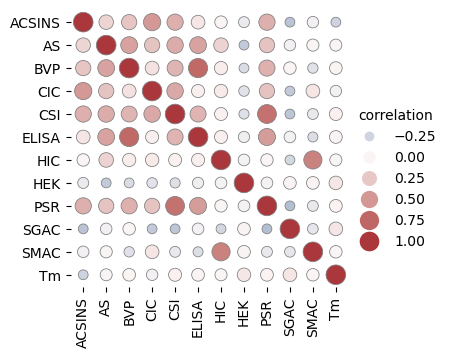

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = results_df

# 상관관계 행렬 계산 시 숫자형 데이터만 사용하도록 수정합니다.
corr_mat = df.corr(numeric_only=True).stack().reset_index(name="correlation")

g = sns.relplot(
    data=corr_mat,
    x="level_0",
    y="level_1",
    hue="correlation",
    size="correlation",
    palette="vlag",
    hue_norm=(-1, 1),
    edgecolor=".5",
    height=4,
    sizes=(50, 200),
    size_norm=(-0.2, 0.8),
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

plt.show()

위 결과를 보면 ACSINS, AS, BVP, CIC, CSI, ELISA, PSR 값은 서로 양의 상관관계를 갖고 있는 것을 알 수 있습니다. 반면 SGAC는 대체로 음의 상관관계를 갖고 있습니다. 이러한 상관관계는 항체의 특정 생물물리학적 특성들이 서로 어떻게 연관되어 있는지를 이해하는 데 도움이 됩니다.

## AbDev 결과 클러스터 맵

클러스터 맵을 통해 AbDev 결과를 시각화합니다. 이를 통해 각 항체의 생물물리학적 특성들이 어떻게 그룹화되는지 확인할 수 있습니다.

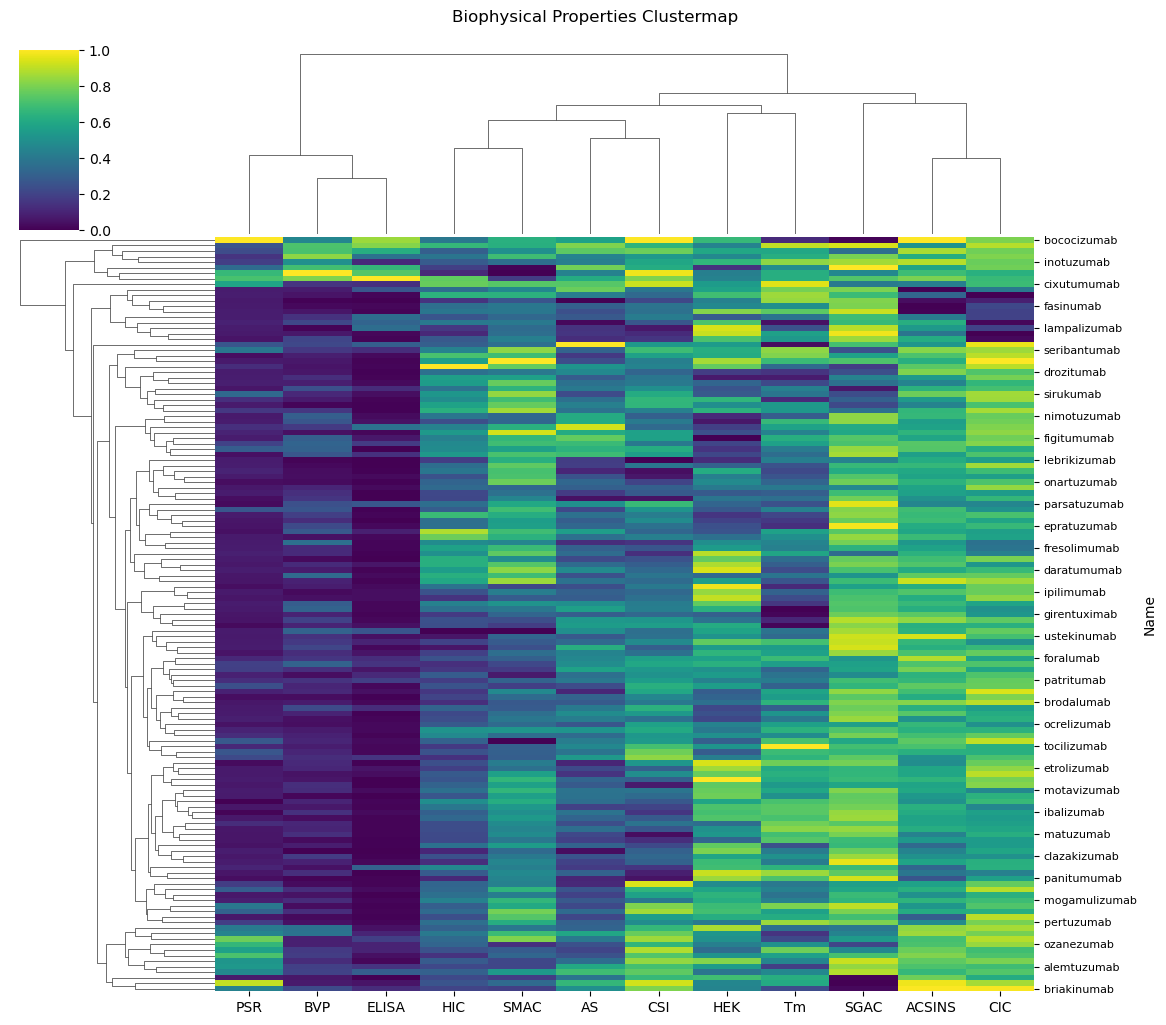

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def create_biophysical_clustermap(df: pd.DataFrame):
    """
    주어진 DataFrame을 사용하여 클러스터 맵을 생성하고 시각화합니다.
    'Name' 열을 인덱스로 설정하고, 나머지 수치형 열을 클러스터 맵에 표시합니다.
    클러스터 맵은 데이터를 계층적으로 클러스터링하여 유사한 데이터 포인트를 그룹화합니다.

    Args:
        df (pd.DataFrame): 'Name' 및 생물물리학적 특성 예측 결과를 포함하는 DataFrame.
    """

    # 'Name' 열을 인덱스로 설정하여 시각화에 사용합니다.
    df_clustermap = df.set_index("Name")

    # 'Name'을 제외한 모든 수치형 데이터를 선택합니다.
    numeric_df = df_clustermap.select_dtypes(include=np.number)

    # Seaborn을 사용하여 클러스터 맵을 그립니다.
    # 클러스터링을 통해 데이터의 숨겨진 패턴을 발견할 수 있습니다.
    # standard_scale=1: 데이터를 표준화하여 각 특성의 스케일을 맞춥니다.
    clustermap = sns.clustermap(
        numeric_df,
        cmap="viridis",
        figsize=(12, 10),
        annot=False,
        standard_scale=1,
        cbar_pos=(0.02, 0.8, 0.05, 0.18),  # 컬러바의 위치와 크기를 조정합니다.
    )

    # Y축 틱 레이블의 폰트 크기를 줄입니다.
    # 올바른 축인 ax_heatmap을 사용하여 Y축 틱 레이블의 폰트 크기를 조정합니다.
    plt.setp(clustermap.ax_heatmap.get_yticklabels(), fontsize=8)

    # 플롯을 화면에 표시합니다.
    plt.suptitle("Biophysical Properties Clustermap", y=1.02)
    plt.show()


# 함수 호출
create_biophysical_clustermap(df)

## DeepViscosity 결과 시각화

DeepViscosity 모델의 예측 결과를 시각화합니다. 이를 통해 각 항체의 점도 등급이 어떻게 분포되어 있는지 확인할 수 있습니다.

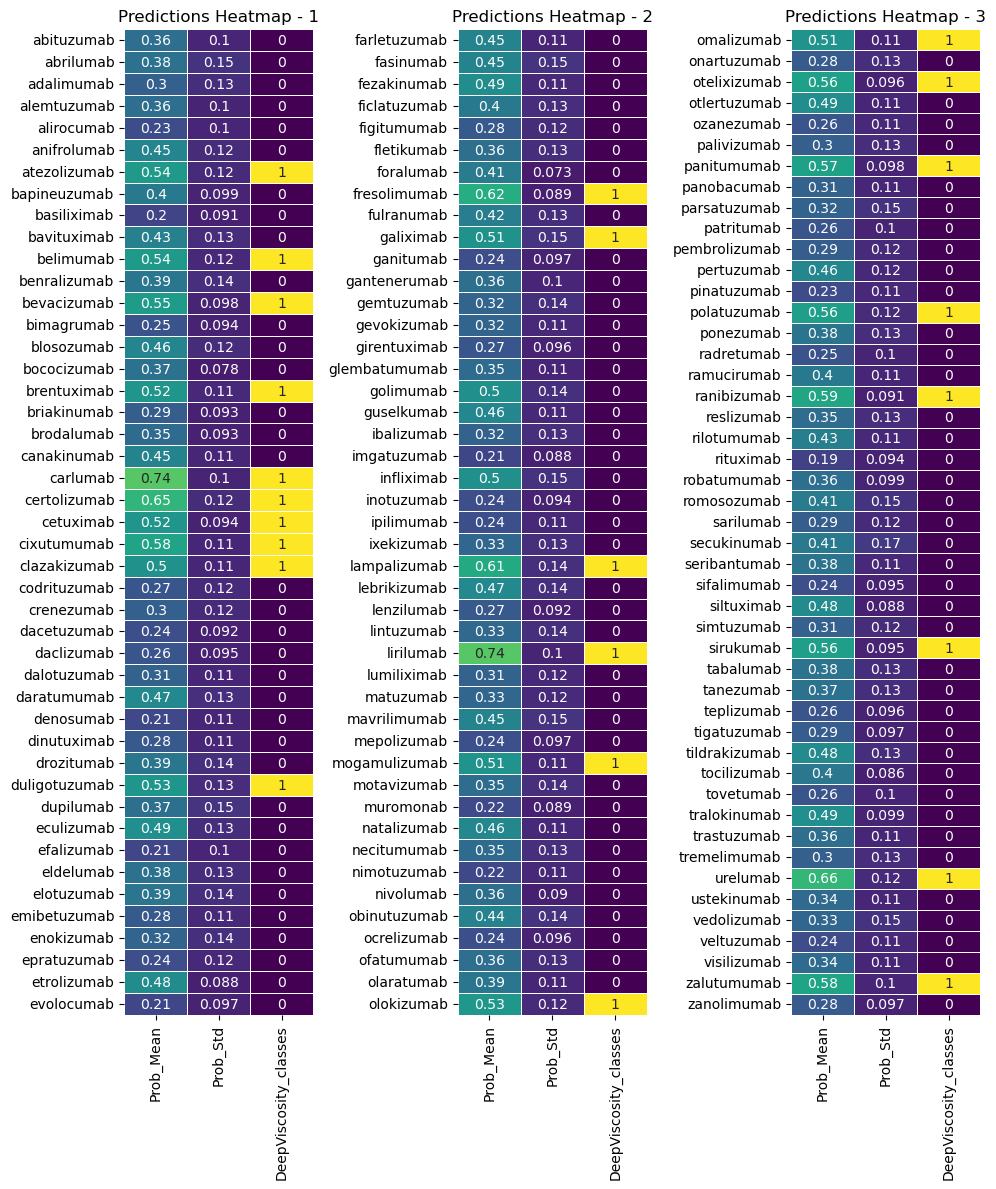

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def create_deepvis_heatmap(df: pd.DataFrame):
    """
    주어진 DataFrame을 사용하여 3개의 서브플롯으로 구성된 히트맵을 생성하고 시각화합니다.
    이 함수는 'Name', 'Prob_Mean', 'Prob_Std', 'DeepViscosity_classes'
    열을 포함하는 데이터프레임을 입력으로 받습니다.

    Args:
        df (pd.DataFrame): 'Name' 및 수치형 예측 결과를 포함하는 DataFrame.
                          (예: df_deepvis)
    """

    # 히트맵을 위해 'Name' 열을 인덱스로 설정합니다.
    df_heatmap = df.set_index("Name")

    # 히트맵에 사용할 수치형 데이터만 선택합니다.
    numeric_df = df_heatmap[["Prob_Mean", "Prob_Std", "DeepViscosity_classes"]]

    # 데이터를 3개의 서브플롯으로 분할합니다.
    chunk_size = len(numeric_df) // 3
    chunks = [numeric_df.iloc[i * chunk_size : (i + 1) * chunk_size] for i in range(2)]
    chunks.append(numeric_df.iloc[2 * chunk_size :])

    # 3개의 서브플롯이 있는 figure를 생성합니다.
    # figsize를 조정하여 전체적인 크기를 보기 좋게 만듭니다.
    fig, axes = plt.subplots(1, 3, figsize=(10, 12))

    # 각 서브플롯에 히트맵을 그립니다.
    for i, ax in enumerate(axes):
        sns.heatmap(
            chunks[i],
            ax=ax,
            annot=True,
            cmap="viridis",
            linewidths=0.5,
            cbar=False,
            cbar_kws={"label": "Value"},
        )
        ax.set_title(f"Predictions Heatmap - {i + 1}")
        ax.set_xlabel("")
        ax.set_ylabel("")

    # 전체 레이아웃을 조정합니다.
    plt.tight_layout()

    # 플롯을 화면에 표시합니다.
    plt.show()


create_deepvis_heatmap(df_deepvis)

# 결론

이번 튜토리얼을 통해 우리는 서열 데이터만을 사용해 항체 의약품 개발 가능성을 예측하는 과정을 살펴보았습니다. 물론, 인공지능 모델의 예측이 모든 것을 해결해 주지는 않습니다. 모델의 결과는 하나의 참고 자료일 뿐이며, 실제 개발 과정에서는 다양한 실험과 검증이 필수적입니다. 하지만 [DeepSP](https://github.com/Lailabcode/DeepSP)와 같은 예측 모델은 수많은 후보 물질 중에서 가장 유망한 항체를 선별하는 데 큰 도움을 주어, 개발 시간과 비용을 획기적으로 줄일 수 있습니다.

앞으로 딥러닝과 바이오 기술의 융합은 더욱 가속화될 것입니다. 이 튜토리얼이 여러분에게 항체 의약품 개발이라는 흥미로운 분야에 대한 깊은 이해를 제공하고, 나아가 새로운 연구와 개발의 영감을 불어넣는 계기가 되기를 바랍니다.